In [1]:
# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import SIRT as SIRT_CIL
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation \

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL utilities
from cil.utilities.display import show2D
from cil.utilities import dataexample

# Import from CIL tigre plugin
from cil.plugins.tigre import ProjectionOperator
from cil.plugins.tigre import tigre_algo_wrapper

# Import FBP from CIL recon class
from cil.recon import FBP, FDK

from cil.framework import ImageData

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



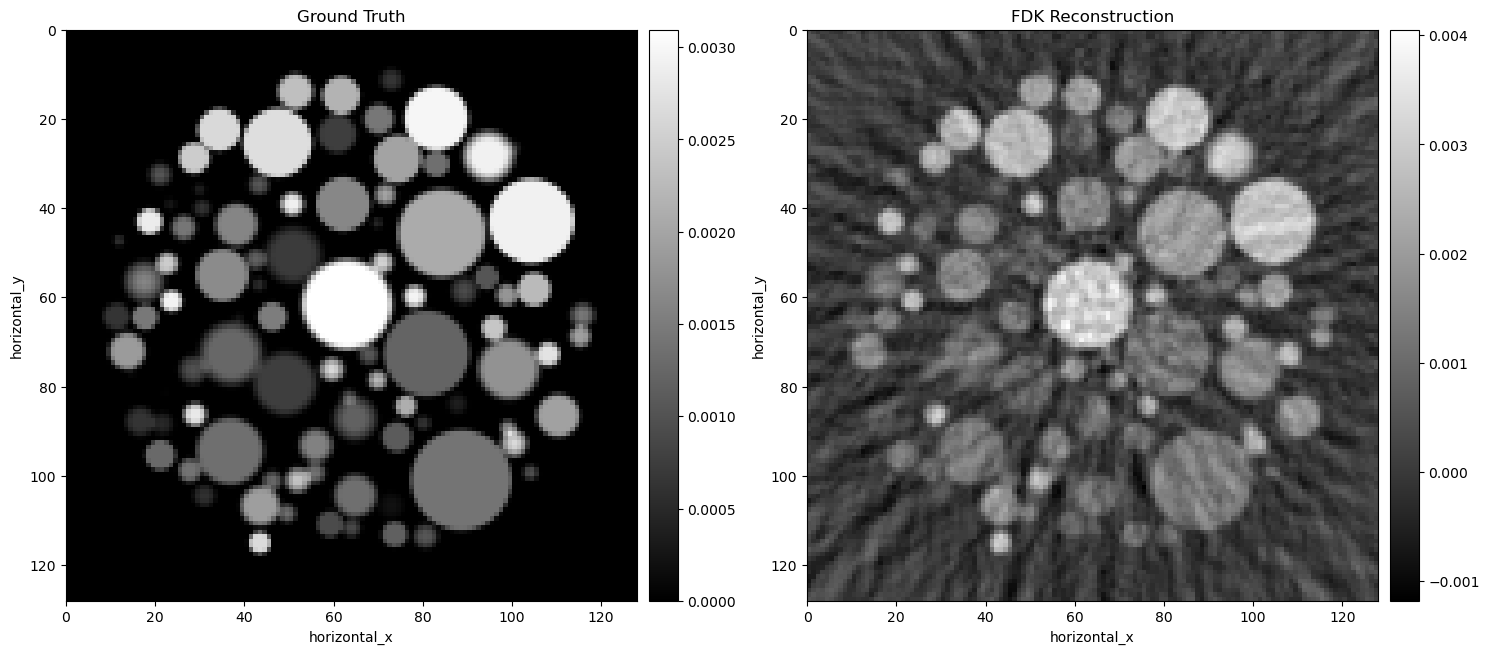

In [2]:
##fan beam data example

ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()

data = data.get_slice(vertical='centre')
ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

In [3]:
algo = tigre_algo_wrapper(name='sart', initial=None, image_geometry=ig, data=absorption, niter=10)
img, qual = algo.process()

SART algorithm in progress.
Estimated time until completion : 00:01:50


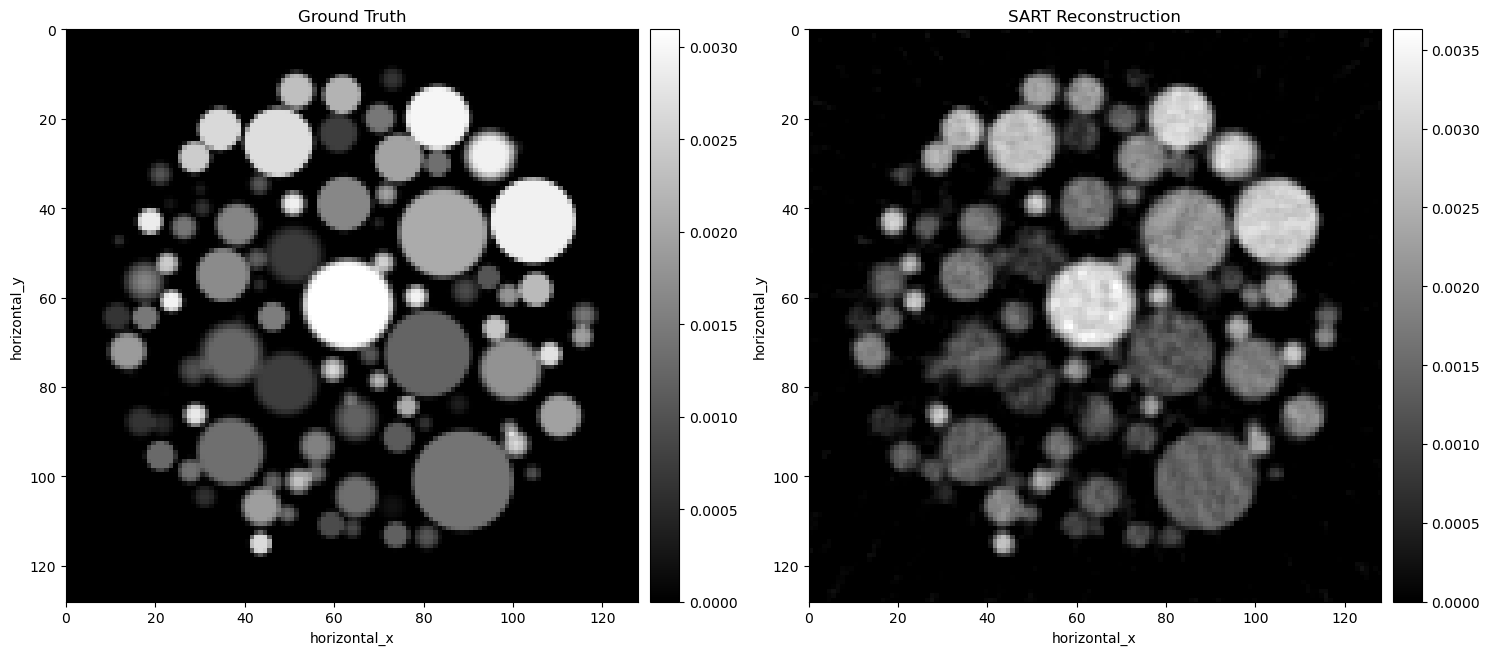

In [4]:
show2D([ground_truth, img], title = ['Ground Truth', 'SART Reconstruction'], origin = 'upper', num_cols = 2);

In [5]:
print('Quality of SART reconstruction: ', qual)

Quality of SART reconstruction:  None
